In [123]:
from functions import *
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures,RobustScaler
from sklearn.linear_model import Ridge,LinearRegression,Lasso,ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.metrics import *
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve, RandomizedSearchCV,KFold,cross_val_score
from sklearn.dummy import DummyRegressor
import pickle

In [124]:
df = pd.read_csv("dataset_clear.csv")

In [125]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'cat_bmi'],
      dtype='object')

In [126]:
feature = df.columns[0:-1]
target = 'charges'
X =df.drop(["charges","bmi"],axis=1)
y = df[target]



In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, random_state=42, train_size = 0.8,stratify=X[["smoker"]])

In [128]:
numerical_features = [
       'age','children'
       ]
categorical_features = [
       'sex' , 'smoker', 'region',"cat_bmi"
       ]



In [129]:


my_col_trans = ColumnTransformer([
    ("sclal",StandardScaler(),numerical_features),
    
    ("one_hot_encoder",OneHotEncoder(handle_unknown='ignore'),categorical_features),
    
])



In [130]:
dummy = DummyRegressor()

In [131]:
dummy.fit(X_train,y_train)
dummy.score(X_train,y_train)

0.0

In [132]:
dummy.score(X_test,y_test)

-0.0010185684988295307

In [133]:
modelLR= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), LinearRegression())
modelLR.fit(X_train,y_train)
modelLR.score(X_train,y_train)


0.8588381209284734

In [134]:
modelLR.score(X_test,y_test)

0.9125868967386107

In [135]:
print(r2_score(modelLR.predict(X_test),y_test))
print(mean_squared_error(modelLR.predict(X_test),y_test,squared=False))

0.903276125273242
3549.8002458341366


In [136]:
modelRidge= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), Ridge(alpha=2))
modelRidge.fit(X_train,y_train)
modelRidge.score(X_train,y_train)

0.8586096597292594

In [137]:
modelRidge.score(X_test,y_test)

0.9148320868155257

In [138]:
print(r2_score(modelRidge.predict(X_test),y_test))
print(mean_squared_error(modelRidge.predict(X_test),y_test,squared=False))

0.9037857493345745
3503.915699791672


In [139]:
# modelLasso= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), Lasso(max_iter=100000,random_state=42))
# parameters = {"lasso__alpha":np.linspace(0.1,100,1000)}
# randm_src = GridSearchCV(estimator=modelLasso, param_grid=parameters,scoring='r2',cv=5)
# randm_src.fit(X_train, y_train)

# modelLasso.set_params(**randm_src.best_params_)
# print(randm_src.best_params_)
# best=randm_src.best_params_

In [140]:
best={'lasso__alpha': 35.900000000000006}

In [141]:
modelLasso= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), Lasso(alpha=best["lasso__alpha"],max_iter=100000,random_state=42))

kfold =KFold(n_splits=5,shuffle=True,random_state=42)
scores = cross_val_score(modelLasso,X_train,y_train)
print(scores)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.83150368 0.85048833 0.84709673 0.89501111 0.80076025]
CV Accuracy: 0.84 (+/- 0.06)


In [142]:
modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)

0.855390416919604

In [143]:
modelLasso.score(X_test,y_test)

0.9184589572469776

In [144]:
print(r2_score(modelLasso.predict(X_test),y_test))
print(mean_squared_error(modelLasso.predict(X_test),y_test,squared=False))

0.9061160815532053
3428.497020618863


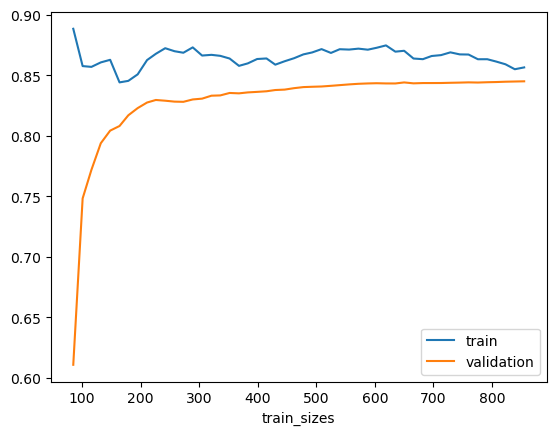

In [145]:
train_sizes, train_scores, test_scores = learning_curve(modelLasso,X_train,y_train,cv=5,train_sizes=np.linspace(0.1, 1.0, 50))                                    
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [146]:
y_pred = modelLasso.predict(X_train)

In [147]:
residual = (y_pred - y_train).abs().sort_values(ascending=False)

In [148]:
residual.describe()

count     1069.000000
mean      2600.014220
std       3811.667124
min          3.627878
25%       1132.199983
50%       1585.148515
75%       2013.160642
max      23915.938278
Name: charges, dtype: float64

In [149]:
y_pred

array([ 9549.39388401, 16740.2171241 , 10896.96268052, ...,
        6703.40981003, 12769.62107145,  4201.81610512])

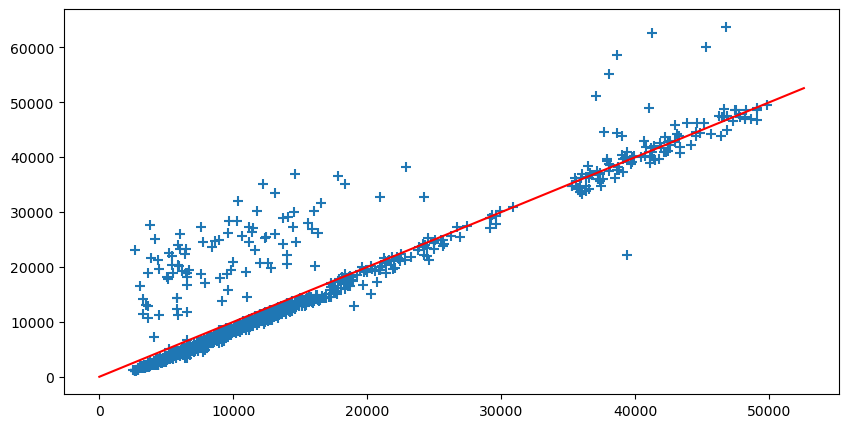

In [150]:
plt.subplots(figsize=(10, 5))
plt.scatter(y_pred,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')
plt.show()


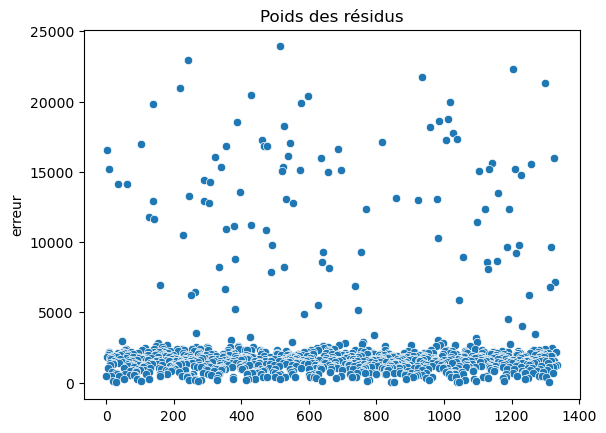

In [151]:


sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()



In [152]:
# to_drop = residual[residual > 10000].index

In [153]:
# X_train.loc[to_drop]

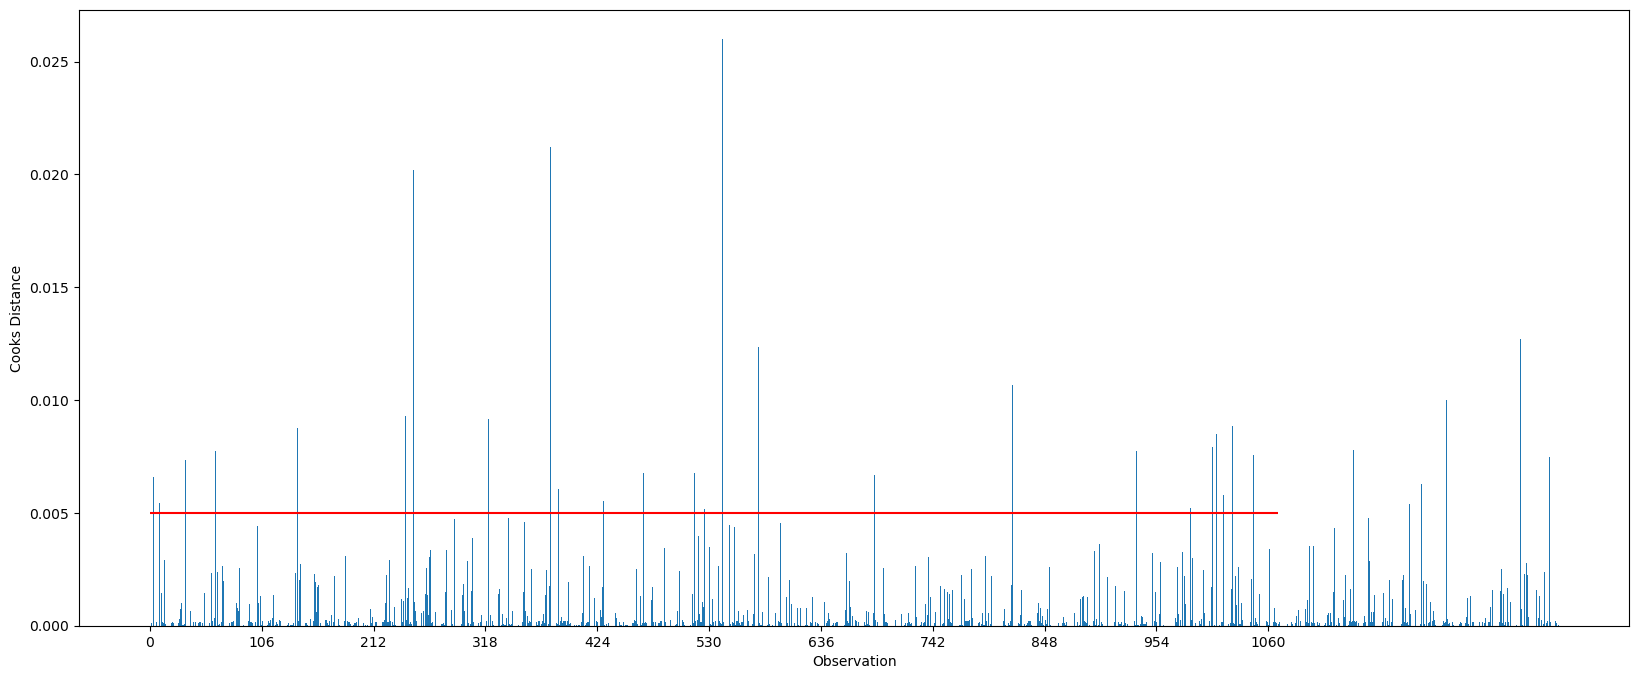

In [154]:


# X_train = X_train.drop(to_drop)
# y_train = y_train.drop(to_drop)
index_to_be_removed = get_index_to_remove_by_Cooks_Distance(X_train=X_train, y_train=y_train, preprocessor=my_col_trans)

X_train = X_train.drop(index=index_to_be_removed.values)
y_train = y_train.drop(index=index_to_be_removed.values)



In [155]:
# parameters = {"lasso__alpha":np.linspace(0.1,100,1000)}
# randm_src = GridSearchCV(estimator=modelLasso, param_grid=parameters,scoring='r2',cv=5)
# randm_src.fit(X_train, y_train)

# modelLasso.set_params(**randm_src.best_params_)
# print(randm_src.best_params_)
modelLasso.set_params(**{'lasso__alpha': 19.500000000000004})


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('sclal', StandardScaler(),
                                                  ['age', 'children']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker', 'region',
                                                   'cat_bmi'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('lasso',
                 Lasso(alpha=19.500000000000004, max_iter=100000,
                       random_state=42))])

In [156]:
kfold =KFold(n_splits=5,shuffle=True,random_state=42)
scores = cross_val_score(modelLasso,X_train,y_train)
print(scores)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.91305108 0.90220999 0.92694567 0.92801455 0.86435548]
CV Accuracy: 0.91 (+/- 0.05)


In [157]:


modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)



0.9133528950298871

In [158]:


modelLasso.score(X_test,y_test)



0.9213288812977192

In [159]:
y_pred = modelLasso.predict(X_train)
residual = (y_pred - y_train).abs().sort_values()

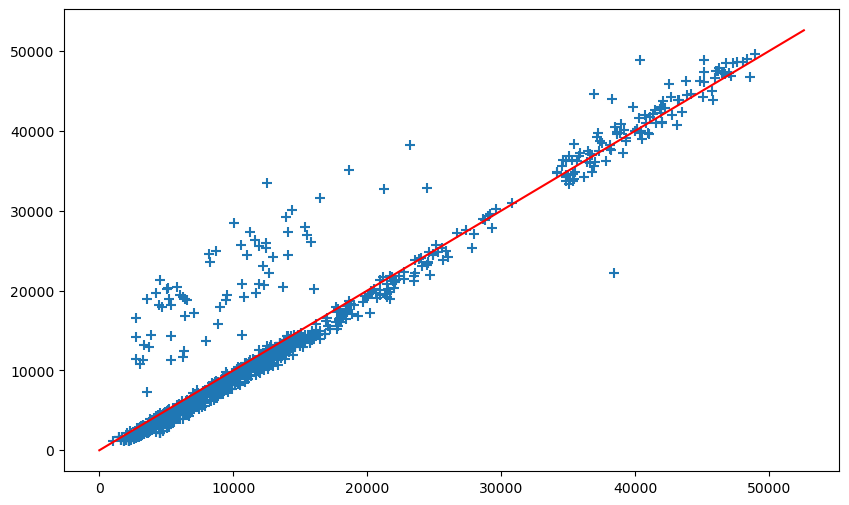

In [160]:
plt.subplots(figsize=(10, 6))
plt.scatter(y_pred,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')
plt.show()

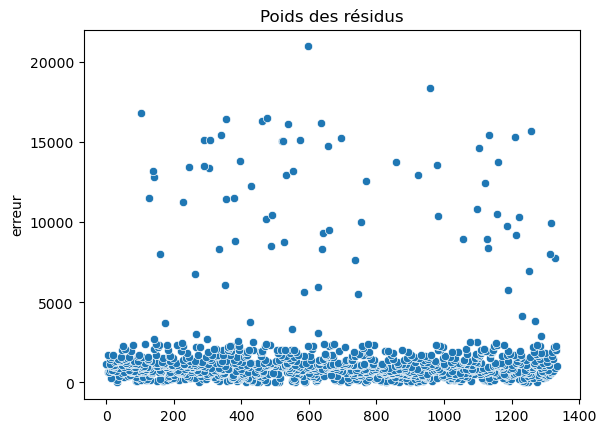

In [161]:
sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

In [162]:
residual.describe()

count     1036.000000
mean      1752.116690
std       2921.695409
min          0.196761
25%        598.282523
50%       1031.019172
75%       1565.422564
max      20971.055594
Name: charges, dtype: float64

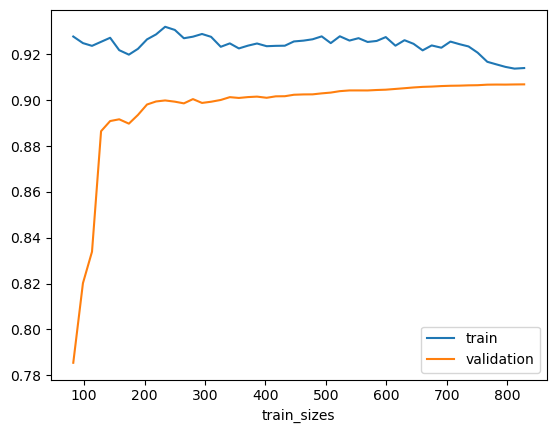

In [163]:

train_sizes, train_scores, test_scores = learning_curve(modelLasso,X_train,y_train,cv=5,train_sizes=np.linspace(0.1, 1.0, 50))   
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [164]:
print(r2_score(modelLasso.predict(X_test),y_test))
print(mean_squared_error(modelLasso.predict(X_test),y_test,squared=False))

0.911126374599167
3367.6217739502813


In [166]:
pickle_out = open("modelLasso.pkl", "wb") 
pickle.dump(modelLasso, pickle_out) 
pickle_out.close()